In [30]:
import numpy as np

from tqdm.auto import tqdm

import matplotlib
import matplotlib.pyplot as plt
import networkx as nx

import matilda
import matilda.prototyping
import matilda.harmonic


In [31]:
SAVEFIG = False


## Example figure 8

In [32]:
from sklearn.datasets import make_circles


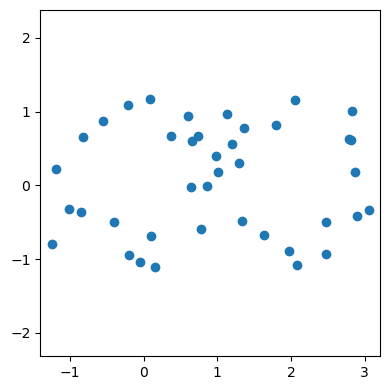

In [33]:
N_POINTS = 20

pt0, _ = make_circles(
    n_samples=(N_POINTS, 0), shuffle=True, noise=0.2, random_state=42, factor=0.2
)

pt1, _ = make_circles(
    n_samples=(N_POINTS, 0), shuffle=True, noise=0.2, random_state=43, factor=0.2
)
pt1 += [2, 0]  # shift to the right

pointcloud = np.concatenate((pt0, pt1))

plt.figure(figsize=(4, 4))
plt.scatter(pointcloud[:, 0], pointcloud[:, 1])
plt.axis("equal")
# plt.axis('off')
plt.tight_layout()
if SAVEFIG:
    plt.savefig("pointcloud_{}.pdf".format(len(pointcloud)))
plt.show()


40 0-dim simplices
780 1-dim simplices
9880 2-dim simplices
0 3-dim simplices


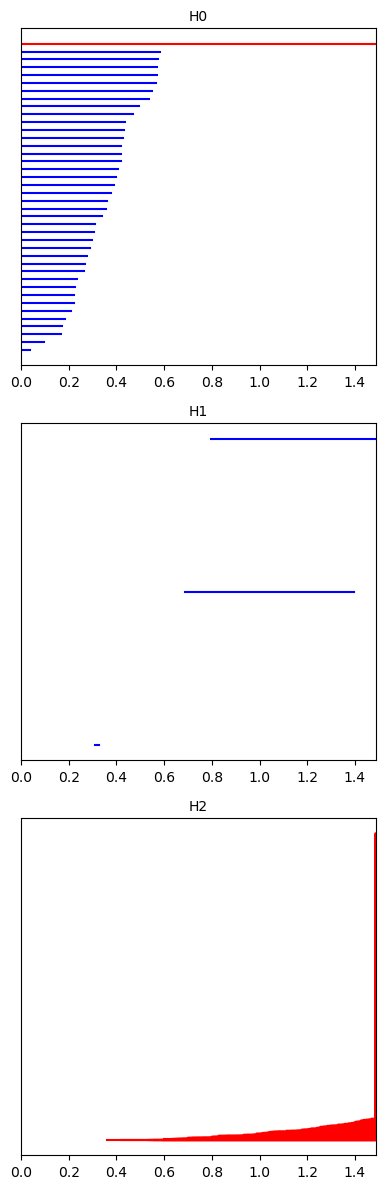

In [34]:
from scipy.spatial import distance_matrix

K_frompoints = matilda.FilteredSimplicialComplex()
K_frompoints.construct_vietoris_from_metric(
    distance_matrix(pointcloud, pointcloud), dimension=2, upper_bound=10
)

# we need to use the prototype class
K = matilda.prototyping.FilteredSimplicialComplex(
    dimension=K_frompoints.dimension,
    simplices=K_frompoints.simplices,
    simplices_indices=K_frompoints.simplices_indices,
    appears_at=K_frompoints.appears_at,
)

for i in range(K.dimension + 1):
    print(
        "{} {}-dim simplices".format(
            len([s for s in K.simplices if len(s) == (i + 1)]), i
        )
    )

homology_computer = matilda.PersistentHomologyComputer()
homology_computer.compute_persistent_homology(K, with_representatives=True, modulus=0)

plotter = matilda.plot.Plotter()
fig, ax = plotter.plot_barcode(
    homology_computer,
    dimension=[d for d in range(K.dimension)],
    figsize=(4, 4 * K.dimension),
)

plt.tight_layout()
if SAVEFIG:
    plt.savefig("barcode_H1_{}.pdf".format(len(pointcloud)))
plt.show()


In [35]:
harmonic_computer = matilda.harmonic.HarmonicRepresentativesComputer(
    K, homology_computer
)

harmonic_computer.compute_harmonic_cycles(dim=1, verbose=1)


no cycles selected, projecting all 3 1-dimensional cycles
computing harmonic representatives in dimension 1
there are 3 homology classes


  0%|          | 0/3 [00:00<?, ?it/s]

In [36]:
for id in harmonic_computer.harmonic_cycles[1].keys():
    print(
        "standard {:.2f}, harmonic {:.2f}".format(
            np.linalg.norm(
                [i for _, i in homology_computer.persistent_cycles[1][id].items()]
            ),
            np.linalg.norm(
                [i for _, i in harmonic_computer.harmonic_cycles[1][id].items()]
            ),
        )
    )


standard 2.00, harmonic 2.00
standard 4.24, harmonic 2.76
standard 4.58, harmonic 2.07


In [37]:
# let's record all weights of simplices in any harmonic repr
weights_dict = {}

for c in harmonic_computer.harmonic_cycles[1]:
    for k, w in harmonic_computer.harmonic_cycles[1][c].items():
        s = tuple(K.simplices[k])

        weights_dict[k] = weights_dict.get(k, 0) + np.abs(w)


In [38]:
for i, w in weights_dict.items():
    if w > 1:
        print("{:.2f} {}".format(w, i))


1.07 48
1.03 50
1.04 51
1.02 56
1.04 57
1.02 61
1.02 81
1.02 141
1.02 222


### The harmonic representatives

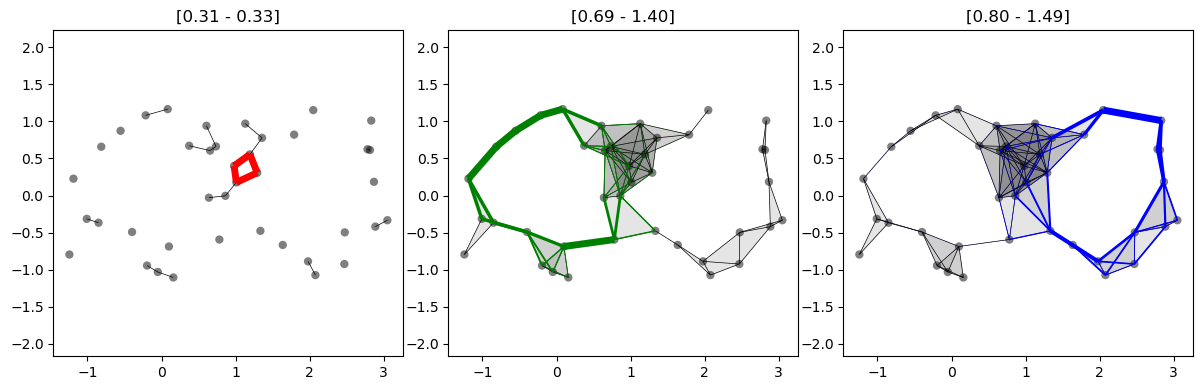

In [39]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))

c = ["red", "green", "blue"]

for i, id in enumerate(harmonic_computer.harmonic_cycles[1].keys()):
    plotter.plot_2skel(
        K,
        max_id=id,
        pos={i: p for i, p in enumerate(pointcloud)},
        vertices_color=["black"],
        t_alpha=0.2,
        this_ax=axs[i],
    )

    lines_0, w_0 = plotter.plot_1cycle(
        harmonic_computer.harmonic_cycles[1][id], K, pointcloud
    )

    lg0 = matplotlib.collections.LineCollection(lines_0, color=c[i], linewidths=w_0 * 5)
    axs[i].add_collection(lg0)

    axs[i].axis("equal")
    axs[i].set_title("[{:.2f} - {:.2f}]".format(*homology_computer.bars[1][id]))

plt.tight_layout()
if SAVEFIG:
    plt.savefig("{}_points_matilda.pdf".format(len(pointcloud)))
plt.show()


### Cumulative absolute weights

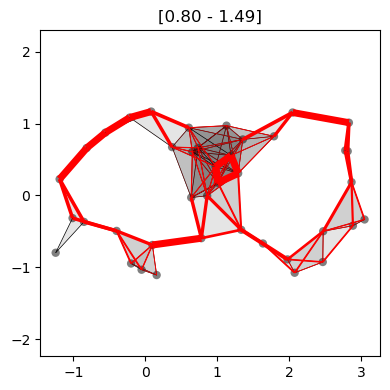

In [40]:
fig, axs = plt.subplots(ncols=1, figsize=(4, 4))

id = list(harmonic_computer.harmonic_cycles[1].keys())[-1]
plotter.plot_2skel(
    K,
    max_id=id,
    pos={i: p for i, p in enumerate(pointcloud)},
    vertices_color=["black"],
    t_alpha=0.2,
    this_ax=axs,
)

lines_0, w_0 = plotter.plot_1cycle(weights_dict, K, pointcloud)

lg0 = matplotlib.collections.LineCollection(lines_0, color="red", linewidths=w_0 * 5)
axs.add_collection(lg0)

axs.axis("equal")
axs.set_title("[{:.2f} - {:.2f}]".format(*homology_computer.bars[1][id]))

plt.tight_layout()
if SAVEFIG:
    plt.savefig("{}_points_matilda.pdf".format(len(pointcloud)))
plt.show()


### weights normalized by the bar len

In [41]:
homology_computer.bars[1]


{57: [0.3105279803276062, 0.32616326212882996],
 222: [0.687453031539917, 1.397553563117981],
 293: [0.7954891324043274, 1.4865864515304565]}

In [42]:
# let's record all weights of simplices in any harmonic repr
normalized_weights_dict = {}

total_bar_len = 0
for c in harmonic_computer.harmonic_cycles[1]:
    total_bar_len += homology_computer.bars[1][c][1] - homology_computer.bars[1][c][0]

for c in harmonic_computer.harmonic_cycles[1]:
    len_bar = homology_computer.bars[1][c][1] - homology_computer.bars[1][c][0]

    print(
        "id {} -  bar len {:.2f} - bar weight {:.2f}".format(
            c, len_bar, len_bar / total_bar_len
        )
    )

    for k, w in harmonic_computer.harmonic_cycles[1][c].items():
        normalized_weights_dict[k] = (
            normalized_weights_dict.get(k, 0) + np.abs(w) * len_bar / total_bar_len
        )


id 57 -  bar len 0.02 - bar weight 0.01
id 222 -  bar len 0.71 - bar weight 0.50
id 293 -  bar len 0.69 - bar weight 0.49


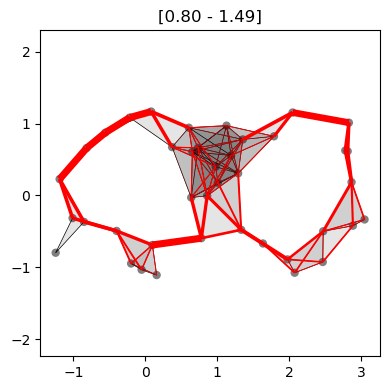

In [43]:
fig, axs = plt.subplots(ncols=1, figsize=(4, 4))

id = list(harmonic_computer.harmonic_cycles[1].keys())[-1]
plotter.plot_2skel(
    K,
    max_id=id,
    pos={i: p for i, p in enumerate(pointcloud)},
    vertices_color=["black"],
    t_alpha=0.2,
    this_ax=axs,
)

lines_0, w_0 = plotter.plot_1cycle(normalized_weights_dict, K, pointcloud)

lg0 = matplotlib.collections.LineCollection(lines_0, color="red", linewidths=w_0 * 10)
axs.add_collection(lg0)

axs.axis("equal")
axs.set_title("[{:.2f} - {:.2f}]".format(*homology_computer.bars[1][id]))

plt.tight_layout()
if SAVEFIG:
    plt.savefig("{}_points_matilda.pdf".format(len(pointcloud)))
plt.show()
